# Exploratory data analysis

## Imports

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

## Load the data

Lists that have been stored in CSV aren't automatically parsed by `pandas`. Thus this small function converts a string in the form `'{'banana', 'orange', 'tangerine'}'` in a Python list containing the same elements

In [5]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("{}").replace("'", "").split(", ")]

Simply use `read_csv` to import the data. We ignore the first column since we do not need these repeating ids. We can then apply our `string_to_list` function to the list of hashtags

In [6]:
tiktoks = pd.read_csv("data/tiktoks.csv", usecols=range(1,8), parse_dates=["date"])
tiktoks.hashtags = tiktoks.hashtags.apply(string_to_list)
tiktoks.head(5)

,video_id,hashtags,date,user_id,n_likes,n_comments,n_shared
0,1837067303714442366,"[aussie, biden2020, bidenharris2020, straya]",2020-11-07 01:51:07,1192012069979362808,8300000,83600,238000
1,4899762877921143731,"[biden2020, election2020, foryou, viral, fürdi...",2020-11-06 18:11:03,738634680110129777,7200000,157500,536700
2,-3337063503762208334,"[foryoupage, biden2020, fyp, foryou]",2020-10-19 18:41:40,3802590914777843757,5000000,105700,400400
3,-8563026770357025091,"[biden2020, trumpsong, viral, parati, repost, ...",2020-06-16 22:41:10,-4673072110752922293,4900000,138500,355900
4,8160608468973820327,[biden2020],2020-10-31 23:04:55,-1858632524192455925,4600000,69500,217800


## Visualitions

We first create a list containing all the hashtags we used to collect the data.

Then we create the DataFrame `tiktoks_exploded` that contains one entry for each hashtags. This means that if a row had hashtags `['Biden2020', 'bidenharris2020']`, the exploded version will transform it in two distinct rows, each with a single hashtag

In [7]:
queried_hashtags = ["Biden2020", "Trump2020", "biden", "trump", "election2020", "2020election", "donaldtrump", "joebiden", "maga", "trumpout",
                    "democrat", "republican", "trumpvsbiden", "bidenvstrump", "voteblue", "votered"]
tiktoks_exploded = tiktoks.explode("hashtags")

Display the distribution of publications of each of the queried hashtags. Each bin represents a period of 10 days.

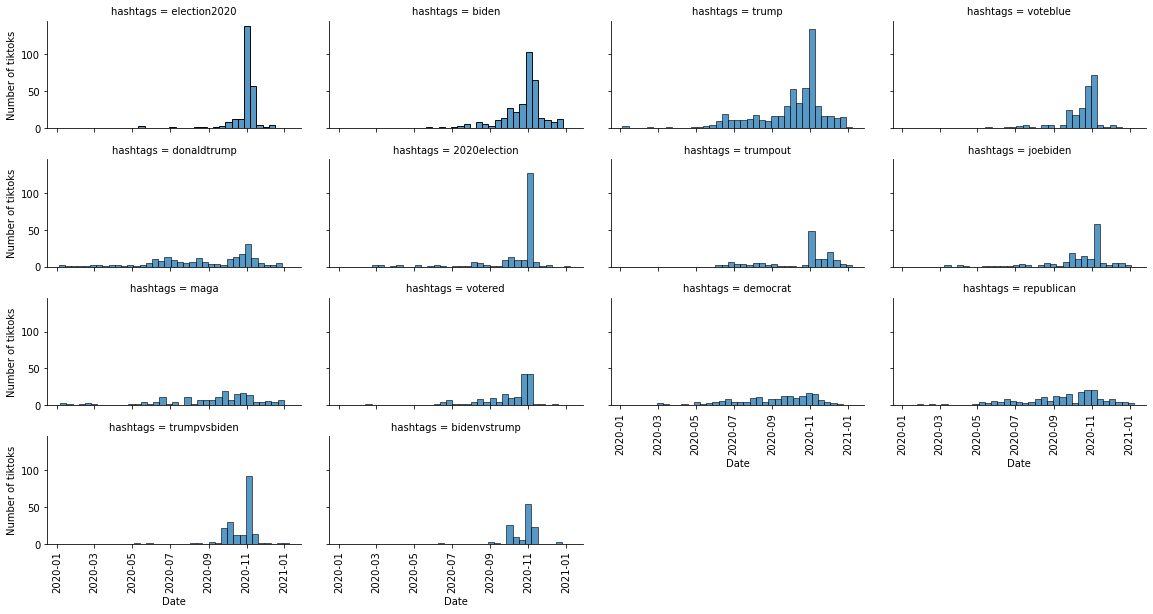

In [8]:
g = sns.FacetGrid(tiktoks_exploded.query("hashtags in @queried_hashtags"), col="hashtags", col_wrap = 4, sharex = True, sharey=True, height = 2, aspect=2)
g.map_dataframe(sns.histplot, x="date", binwidth=10)
g.set_axis_labels("Date", "Number of tiktoks")
g.set_xticklabels(rotation=90)

Display the top 20 most used hashtags in our dataset

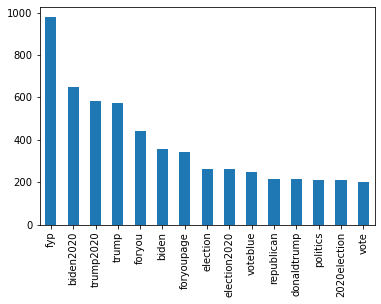

In [9]:
top_10 = tiktoks_exploded.hashtags.value_counts()[:15].plot(kind="bar")

# Looking at the distribution of hashtags overtime

Creating a new column to store only date of the video (to groupby videos based on date)

In [10]:
tiktoks_exploded['only_date'] = pd.to_datetime(tiktoks_exploded['date']).dt.date.astype(dtype='datetime64[ms]')

Grouping the tiktoks based on date and then hastags to the hashtag count perday

In [11]:
tiktoks_hash_grouped = tiktoks_exploded.groupby(["only_date","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktoks_hash_grouped

,only_date,hashtags,count
0,2020-01-03,2020,1
1,2020-01-03,america,1
2,2020-01-03,donaldtrump,1
3,2020-01-03,foryou,1
4,2020-01-03,foryoupagethis,1
...,...,...,...
9319,2020-12-31,newyear2020,1
9320,2020-12-31,trump2020,1
9321,2020-12-31,trumpout,1
9322,2020-12-31,tuluchaesmilucha,1


As there are many hashtags that have occured very less frequent of time compared to others, we remove all the hashtags that have occured less than 25 times

In [12]:
minimum_occurances = 80
hashtag_value_counts = tiktoks_hash_grouped["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()

# hash_list contains the hashtags that have been used more than *minimum_occurances* number of times

In [13]:
tiktok_ht_min_occ = tiktoks_hash_grouped[tiktoks_hash_grouped['hashtags'].isin(hash_list)]

Creating a new dataframe with each hashtag as column and value as the count of hashtag occurance on that day

In [14]:
perday_hashtag_count = tiktok_ht_min_occ.pivot_table(values='count', index="only_date", columns='hashtags', aggfunc='first', fill_value=0)

In [15]:
plt.rcParams["figure.figsize"] = (10,30)

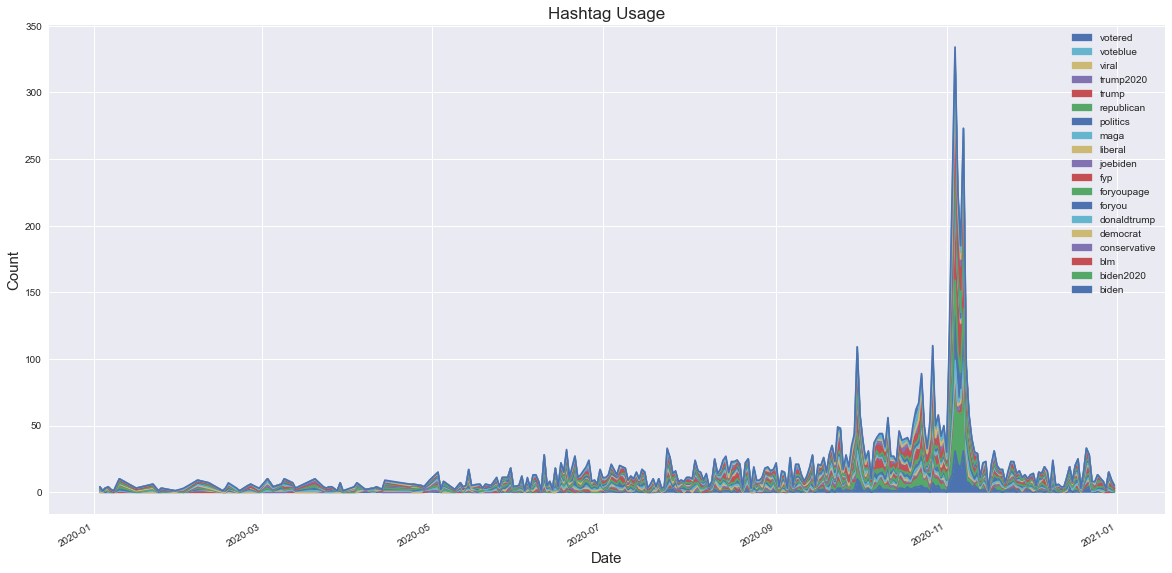

In [16]:
plt.style.use('seaborn')
perday_hashtag_count.plot.area(figsize=(20, 10))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Hashtag Usage', fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)
plt.show()

Similar plot using Seaborn

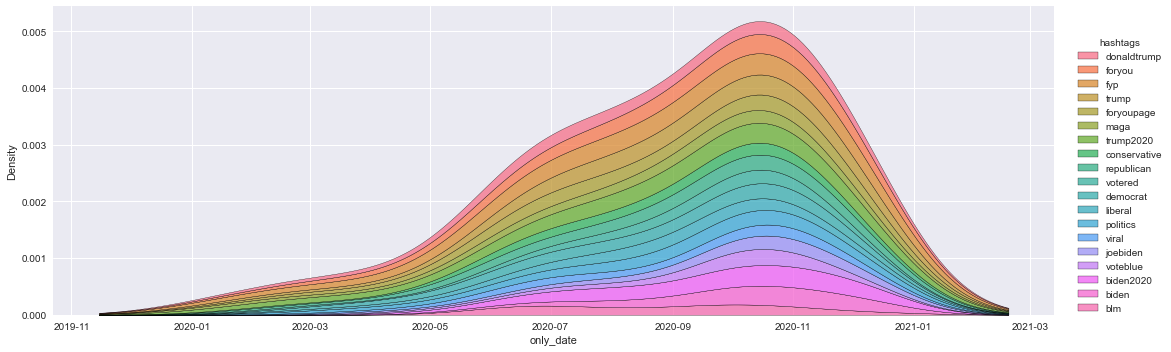

In [17]:
sns.displot(tiktok_ht_min_occ, x="only_date", hue="hashtags", kind="kde", multiple="stack", aspect = 3)

##### Using the area occupied by each hashtag in the plot we can how has the usage shifted over time

1. We should make small plots dividing over time to analyse easily

# Matching TikToks with events

Top 10 days when people posted tiktoks about the elections:

In [69]:
tiktoks["only_date"] = pd.to_datetime(tiktoks['date']).dt.date.astype(dtype='datetime64[ms]')
tiktoks.only_date.value_counts()[:10]

2020-11-04    140
2020-11-07    125
2020-11-05    106
2020-11-03    101
2020-11-06     78
2020-11-02     50
2020-11-08     47
2020-09-30     46
2020-10-27     29
2020-10-23     27
Name: only_date, dtype: int64

* Nov. 2-8 : Election Day was on the 3rd. With all the fuss about the count delays, recounts, fraud claims, etc... the hype lived up until the eighth
* Sep. 30 : The infamous first debate between Biden and Trump that ended up being a shitshow
* Oct. 17 : The Senate confirms ACM to the supreme court one week before the election lol
* Oct. 23 : Second debate between Biden and Trump

# Cooccurances

Creates a co-occurance matrix using pandas

In [18]:
lst = list(tiktoks.hashtags)
u = (pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

v = u.T.dot(u)
v.values[(np.r_[:len(v)], ) * 2] = 0

In [19]:
def plot_co_occurance_matrix(matrix, threshold, figsize):
    fig, axes = plt.subplots(figsize=figsize)
    top_100_indices = matrix[matrix.sum(axis=1) > threshold].index
    print(len(top_100_indices))
    sns.heatmap(matrix[matrix.sum(axis=1) > threshold][list(top_100_indices)])

We plot the co_occurance matrix only using the hashtags with more than 600 occurances

* We observe that (biden, trump) and (biden2020, trump2020) have the most co-occurances. Could it suggest that most TikToks are about the elections in general and not rooting for a particular party ?
* Biden appears a lot with `fyp`, whereas Trump barely does. Does it show that Biden supporters are the more experienced TikTok's user and know that platform better ? Which would also show Biden supporters are the younger generation.
* Without surprise, (Trump, Trump2020) and (Biden, Biden2020) appear often together.
* blm doesn't seem more corrolated to biden than trump

31


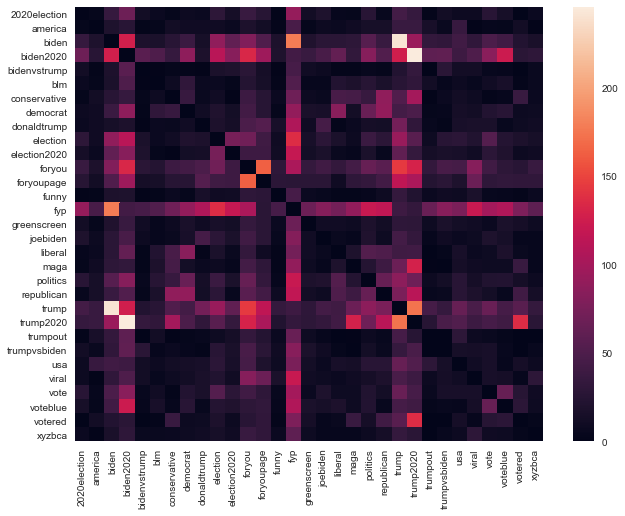

In [21]:
plot_co_occurance_matrix(v, 600, (10.5,8))

Let us now try to get a 2D embedding of each word from this co-occurance matrix by using the Truncated SVD from SkLearn

In [22]:
tsvd = TruncatedSVD(n_components=2)
v_transformed = tsvd.fit_transform(v)

We only keep the embeddings of the hashtags with more than 600 occurances

In [23]:
top_600_indices = list(v[v.sum(axis=1) > 600].index)
v_transformed_reduced = v_transformed[v.sum(axis=1) > 600]

Plot the embeddings

In [52]:
def plot_embeddings(words, vec, figsize):
    fig, axes = plt.subplots(figsize=(10,10))
    for i,word in enumerate(words):
        x = vec[i][0]
        y = vec[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y+0.01, word, fontsize=9)
    plt.show()

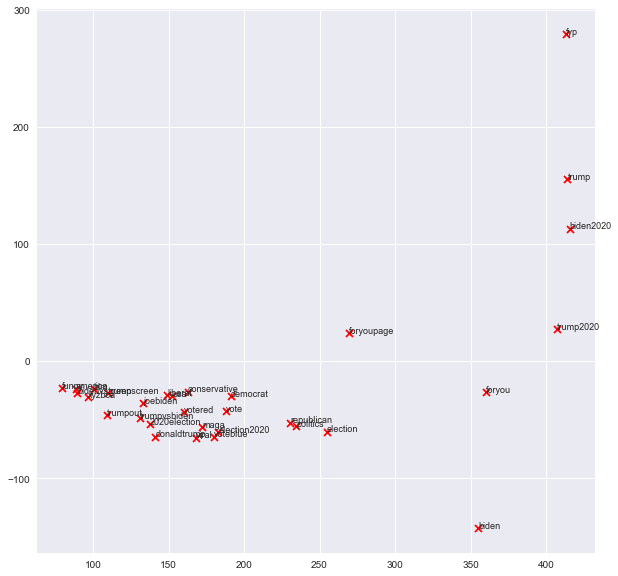

In [53]:
plot_embeddings(top_600_indices, v_transformed_reduced, (10,10))

In [62]:
model = Word2Vec(sentences=tiktoks.hashtags, vector_size=2, window=3, min_count=1, workers=4)
vecs = []
for hashtag in top_600_indices:
    vecs.append(model.wv[hashtag])

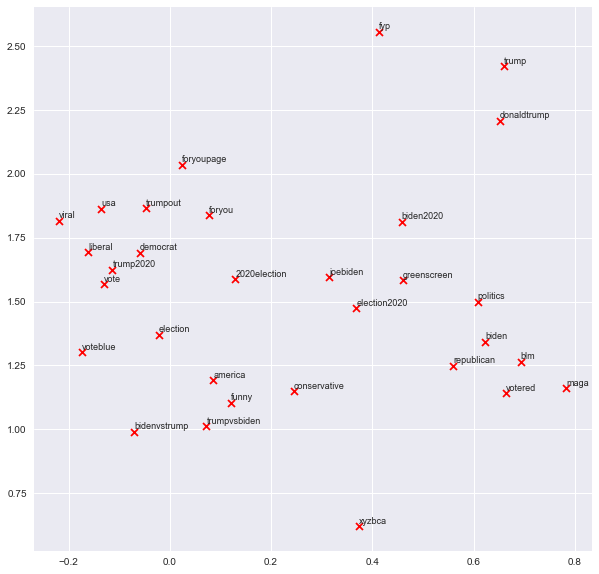

In [63]:
plot_embeddings(top_600_indices, vecs, (10,10))

Let's try to plot the heatmap of the word embeddings using the cosine similarity

In [97]:
vec_length = 10
model = Word2Vec(sentences=tiktoks.hashtags, vector_size=vec_length, window=2, min_count=1, workers=4)
vecs = np.empty((len(top_600_indices),vec_length))
for i in range(len(top_600_indices)):
    vecs[i] = model.wv[top_600_indices[i]]

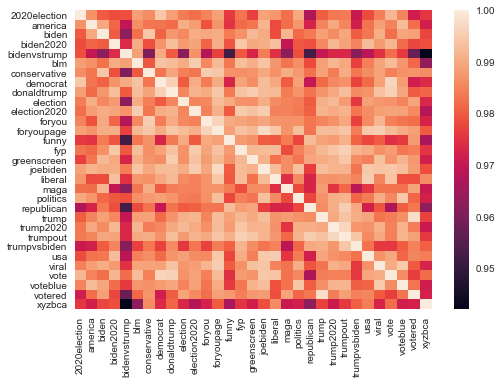

In [98]:
ax = sns.heatmap(cosine_similarity(vecs), xticklabels=top_600_indices, yticklabels=top_600_indices)

# User Clustering using hashtags

Create a user profile based on hashtags i.e create a bag of hashtag vector.

First, we select the hashtags with minimum occurances

In [15]:
tiktoks_exploded_ht_min = tiktoks_exploded[tiktoks_exploded['hashtags'].isin(hash_list)]

In [16]:
tiktok_users = tiktoks_exploded_ht_min.groupby(["user_id","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktok_users

,user_id,hashtags,count
0,-9220189372756105582,biden2020,1
1,-9219936299495992086,voteblue,1
2,-9210628484904479324,foryou,2
3,-9210628484904479324,fyp,2
4,-9201848304446821256,biden2020,1
...,...,...,...
4887,9222623054738295522,trump2020,4
4888,9222812688339128845,biden2020,1
4889,9222812688339128845,foryou,1
4890,9222812688339128845,fyp,1


In [17]:
user_hashtag_vec = tiktok_users.pivot_table(values='count', index="user_id", columns='hashtags', aggfunc='first', fill_value=0)

In [18]:
user_hashtag_vec

hashtags,biden,biden2020,blm,conservative,democrat,donaldtrump,foryou,foryoupage,fyp,joebiden,liberal,maga,politics,republican,trump,trump2020,viral,voteblue,votered
user_id,,,,,,,,,,,,,,,,,,,
-9220189372756105582,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-9219936299495992086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
-9210628484904479324,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0
-9201848304446821256,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
-9196931280306882735,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9196624276725995507,2,2,0,1,0,0,0,0,2,0,1,0,2,0,2,2,0,0,0
9205930827974996326,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9214684972920705785,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
# lost the link to source website where I (Ravi) has taken the code from

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(user_hashtag_vec)

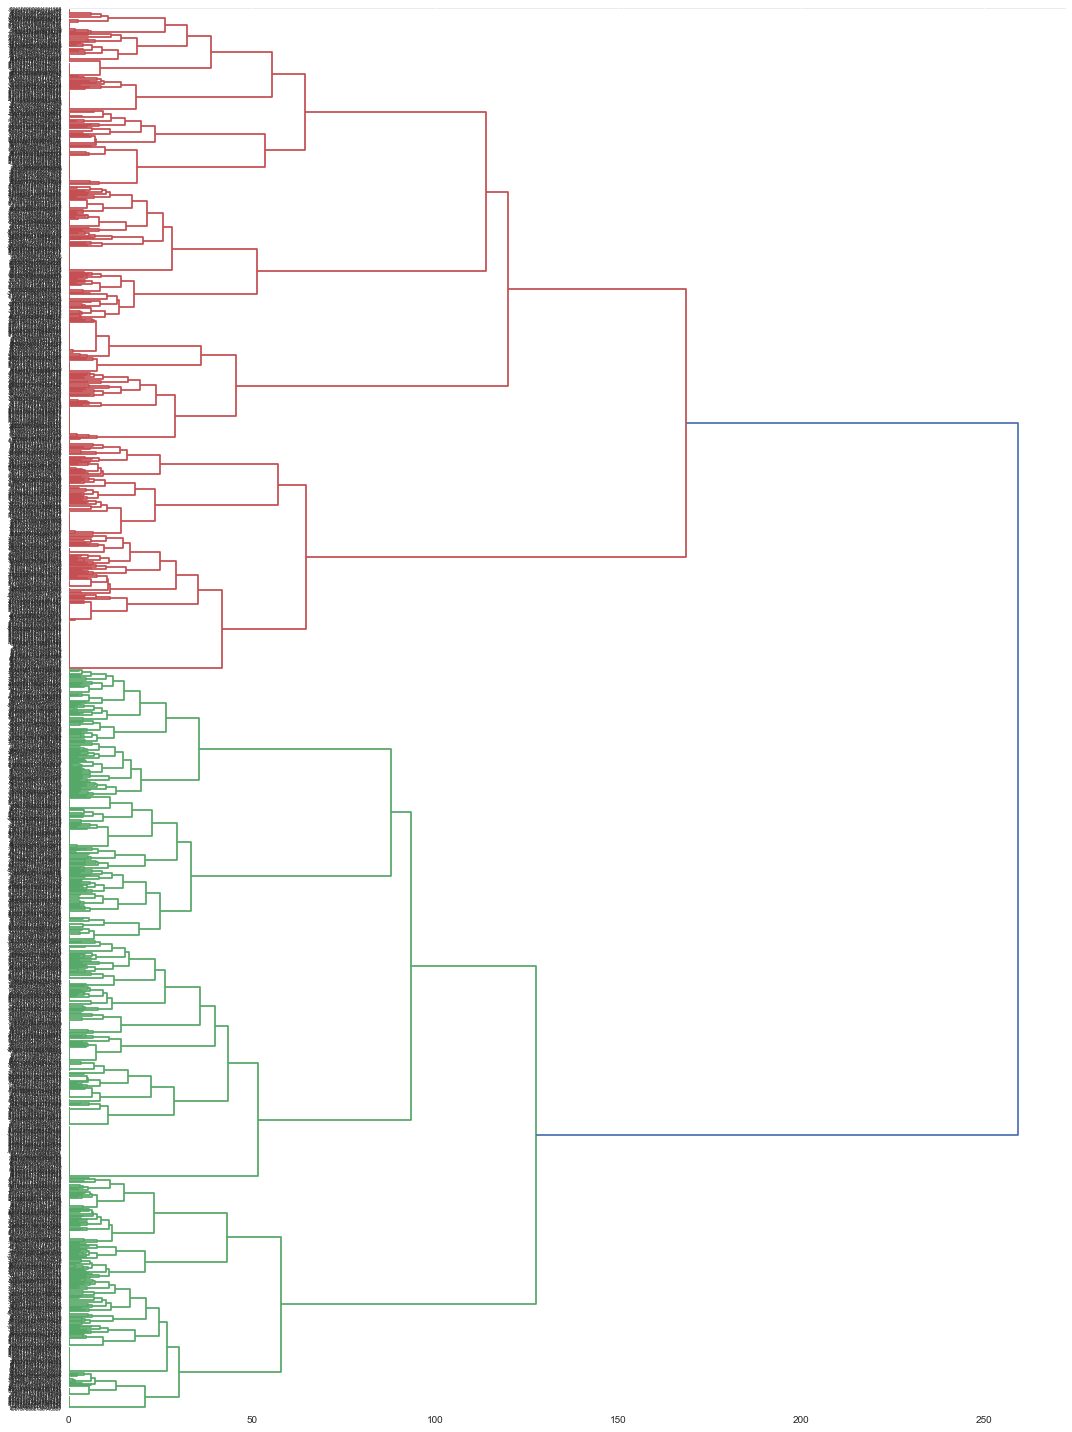

In [21]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=user_hashtag_vec.index.tolist());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout